In [2]:
import z5py
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import elf.segmentation as eseg
from elf.segmentation.utils import normalize_input
from skimage.measure import label

# Open dataset

In [4]:
scratch_dir = Path("/scratch/buglakova")
predictions_dir = scratch_dir / "F107_bin2_619-639_predictions"
predictions_dir.mkdir(parents=True, exist_ok=True)
train_n5_path = predictions_dir / "train.n5"
train_pred_n5_path = predictions_dir / "train_predictions.n5"

In [5]:
f = z5py.File(train_pred_n5_path, "r")
f_raw = z5py.File(train_n5_path, "r")

In [6]:
print(train_pred_n5_path)

/scratch/buglakova/F107_bin2_619-639_predictions/train_predictions.n5


In [7]:
print(train_n5_path)

/scratch/buglakova/F107_bin2_619-639_predictions/train.n5


In [8]:
def read_raw(f: z5py.File):
    raw = f["raw"]["raw_data"]
    raw.n_threads = 8
    print("Reading raw data into memory")
    raw = raw[:]
    return raw

In [15]:
raw = read_raw(f_raw)
fg_mask = np.array([get_fg_mask(img) for img in raw])

Reading raw data into memory


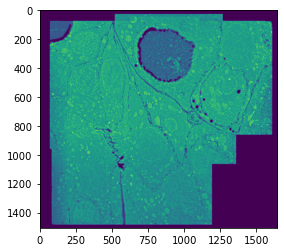

In [10]:
plt.imshow(raw[1, ...])

In [4]:
raw = f_raw["raw"]["raw_data"][:]
g = f["predictions"]
boundaries = g["boundaries"][:]
extra = g["extracellular"][:]
bg = g["background"][:]
# fg = g["foreground"][:]

In [6]:
raw.shape

(9, 1506, 1647)

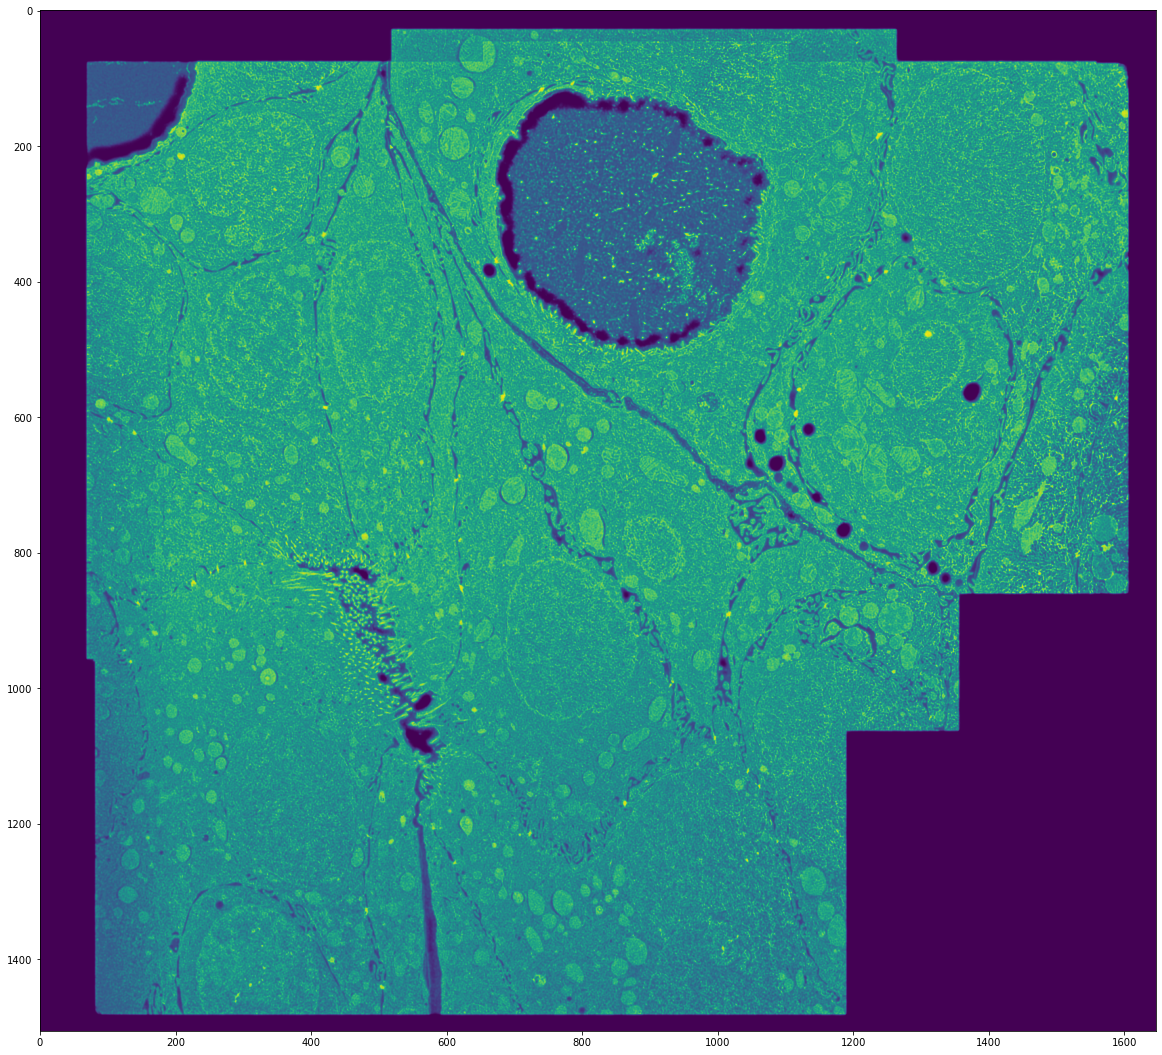

In [53]:
plt.figure(figsize=(20, 20))
plt.imshow(raw[1, ...])

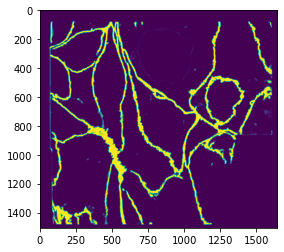

In [8]:
plt.imshow(boundaries[0, ...])

# Run watershed

In [14]:
def get_fg_mask(img: np.ndarray):
    bg = label(img == 0)
    component_sizes = [np.count_nonzero(bg == i) for i in np.unique(bg)[1:]]
    bg_ind = np.argmax(component_sizes) + 1
    bg = (bg == bg_ind)
    fg = (bg != bg_ind)
    return fg

In [45]:
fg_mask = np.array([get_fg_mask(img) for img in raw])

In [48]:
print("Compute watershed ...")
hmap = normalize_input(boundaries)
ws, _ = eseg.stacked_watershed(hmap, mask=fg_mask, n_threads=8, threshold=0.4, sigma_seeds=2.0)

Compute watershed ...


In [55]:
def run_multicut(ws, boundaries):
    rag = eseg.compute_rag(ws, n_threads=8)
    features = eseg.compute_boundary_mean_and_length(rag, boundaries, n_threads=8)
    bg_edges = (rag.uvIds() == 0).any(axis=1)
    z_edges = eseg.features.compute_z_edge_mask(rag, ws)
    costs, edge_sizes = features[:, 0], features[:, -1]
    costs = eseg.compute_edge_costs(
        costs, edge_sizes=edge_sizes, weighting_scheme="xyz", z_edge_mask=z_edges
    )
    # set all the weights to the background to be maximally repulsive
    assert len(bg_edges) == len(costs)
    costs[bg_edges] = -2 * np.max(np.abs(costs))
    node_labels = eseg.multicut.multicut_kernighan_lin(rag, costs)
    seg = eseg.project_node_labels_to_pixels(rag, node_labels, n_threads=8)
    return seg

In [57]:
print("Run multicut ...")
seg = run_multicut(ws, boundaries)

Run multicut ...


In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(seg[5, :, :], cmap="prism")

: 